In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import pandas as pd
from sklearn.linear_model import LinearRegression
from visualisation import plot_team_scatter

pd.set_option('display.max_columns', None)

Inspired by Christopher Davis and the Deep Dive Pod [Youtube link](https://www.youtube.com/watch?v=QvNcnS-2EOY&ab_channel=ChristopherDavis%2CUCIrvine)

In [2]:
def derive_market_power_ratings(year):
    schedule = nfl.import_schedules([year])
    cols_of_interest = [
        'game_id',
        'week',
        'away_team', 
        'home_team',
        'total',
        'spread_line'
    ]
    # weeks_of_interest = list(range(9, 18))
    # df = schedule[schedule['week'].isin(weeks_of_interest)][cols_of_interest].copy()
    df = schedule[cols_of_interest].copy()
    del schedule

    # function to calculate the expected score for home and away based on the spread and total
    exp_home_score = lambda row: (row['total'] + row['spread_line'])/2
    exp_away_score = lambda row: (row['total'] - row['spread_line'])/2

    mean_score = df['total'].mean()/2

    # get the expected scores for each game
    df['exp_away'] = df.apply(exp_away_score, axis=1)
    df['exp_home'] = df.apply(exp_home_score, axis=1)

    # scale them based on the average team score
    df['scaled_away'] = df['exp_away'] - mean_score
    df['scaled_home'] = df['exp_home'] - mean_score

    # create a system of equations where each row represents the coefficients for an offense going against a defense
    system = []
    for _, away_team, home_team, scaled_away, scaled_home in df[['away_team', 'home_team', 'scaled_away', 'scaled_home']].itertuples():
        # Perspective of home team
        # 1 * home_offense - 1 * away_defense + 0.5 * home_field_advantage = home_score
        system.append({
            f'{home_team}_off':  1,
            f'{away_team}_def': -1,
            'hfa': 0.5,
            'score': scaled_home,
        })
        # Perspective of away team (home field hurts you)
        # 1 * away_offense - 1 * home_defense - 0.5 * home_field_advantage = away_score
        system.append({
            f'{away_team}_off':  1,
            f'{home_team}_def': -1,
            'hfa': -0.5,
            'score': scaled_away,
        })

    # create a sorted list of teams
    teams = list(sorted(df['home_team'].unique()))

    # turn the system of equations into a dataframe, fill teams not in that game as 0's
    system_df = pd.DataFrame(system).fillna(0)

    # sort the columns of the system of equations
    sorted_system_cols = list(sorted(system_df.columns))
    sorted_system_cols.remove('hfa')
    sorted_system_cols.remove('score')
    sorted_system_cols += ['hfa', 'score']

    system_df = system_df[sorted_system_cols]

    # use linear regression to solve for the coefficients
    reg = LinearRegression(fit_intercept=False)
    # can use ridge regression to penalize large values if it makes them

    reg.fit(system_df.drop('score', axis=1), system_df['score'])

    hfa = round(reg.coef_[-1], 2)
    
    # dict to hold team ratings
    rating_dict = defaultdict(dict)
    # iterate over offensive and defensive coefficients (ignore hfa and score columns)
    for team_str, rating in zip(system_df.columns[:-2], reg.coef_[:-1]):
        team, unit = team_str.split('_')
        rating_dict[team][unit] = rating

    power_ratings = pd.DataFrame(rating_dict).T
    power_ratings['ovr'] = power_ratings['off'] + power_ratings['def']
    power_ratings = power_ratings[['ovr', 'off', 'def']].copy()
    return power_ratings.sort_values('ovr', ascending=False), hfa

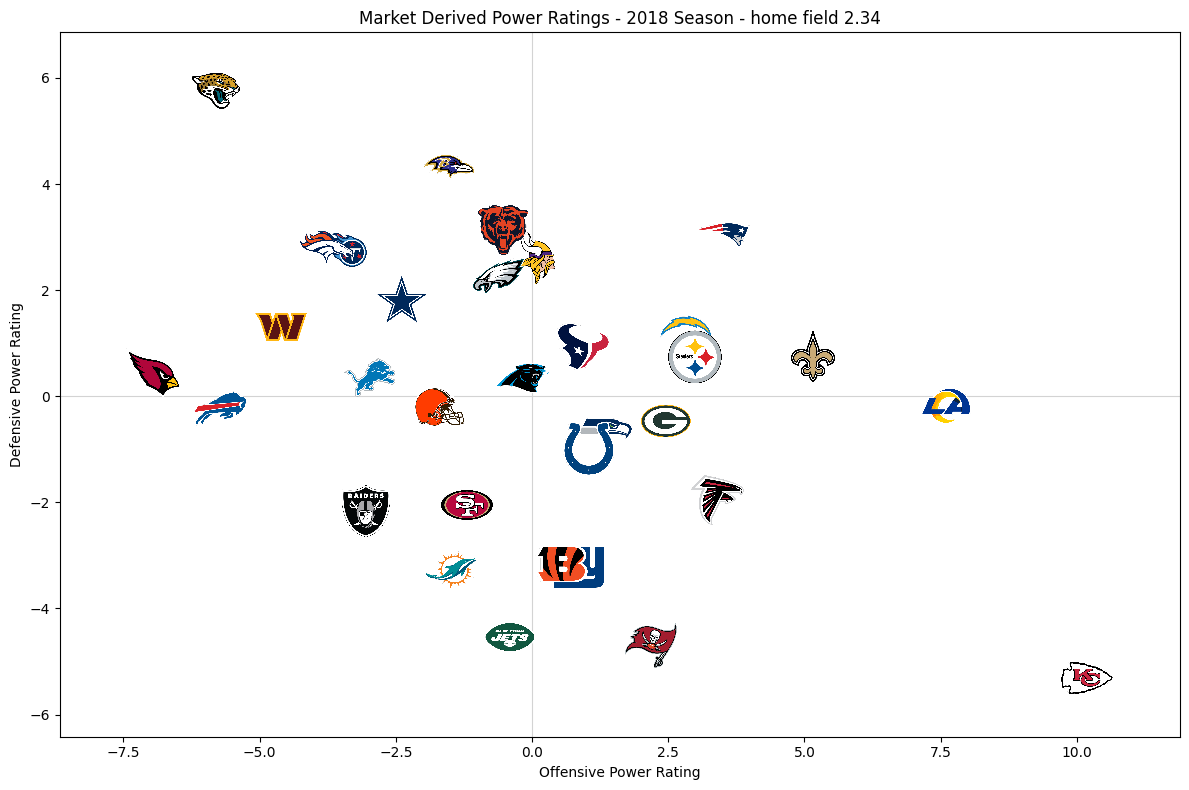

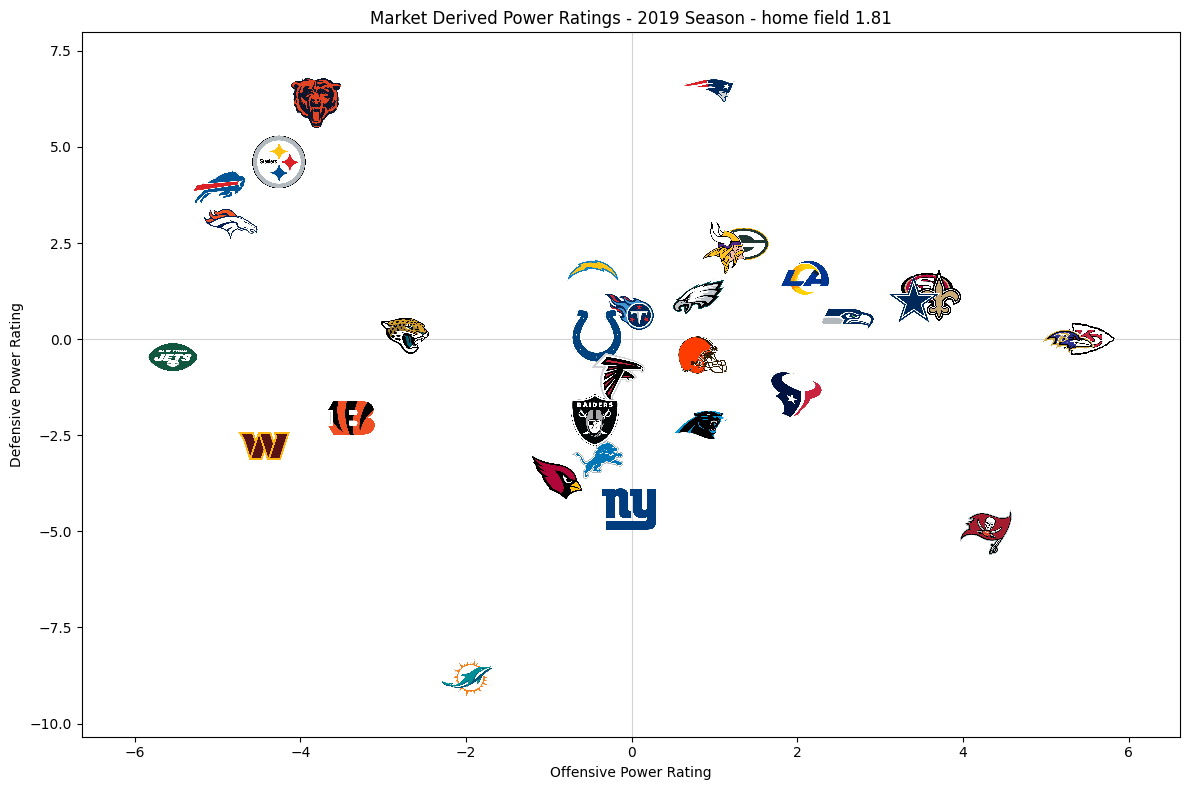

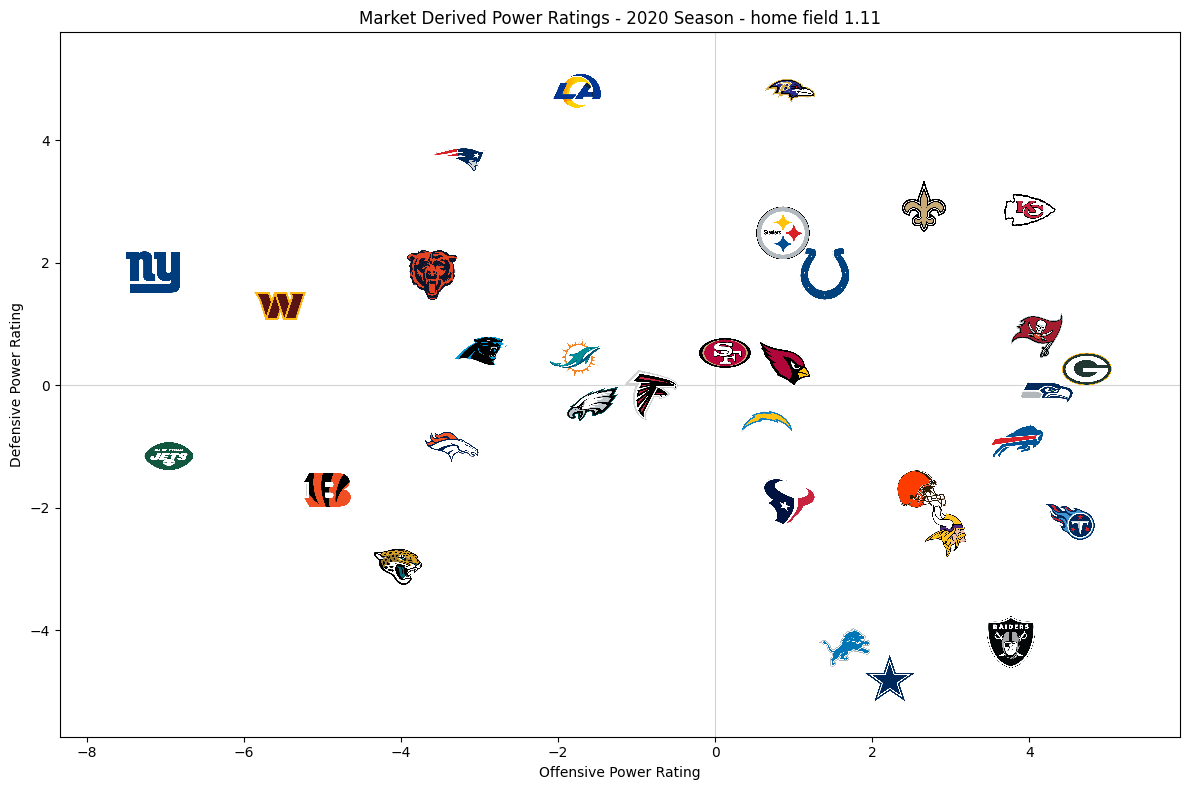

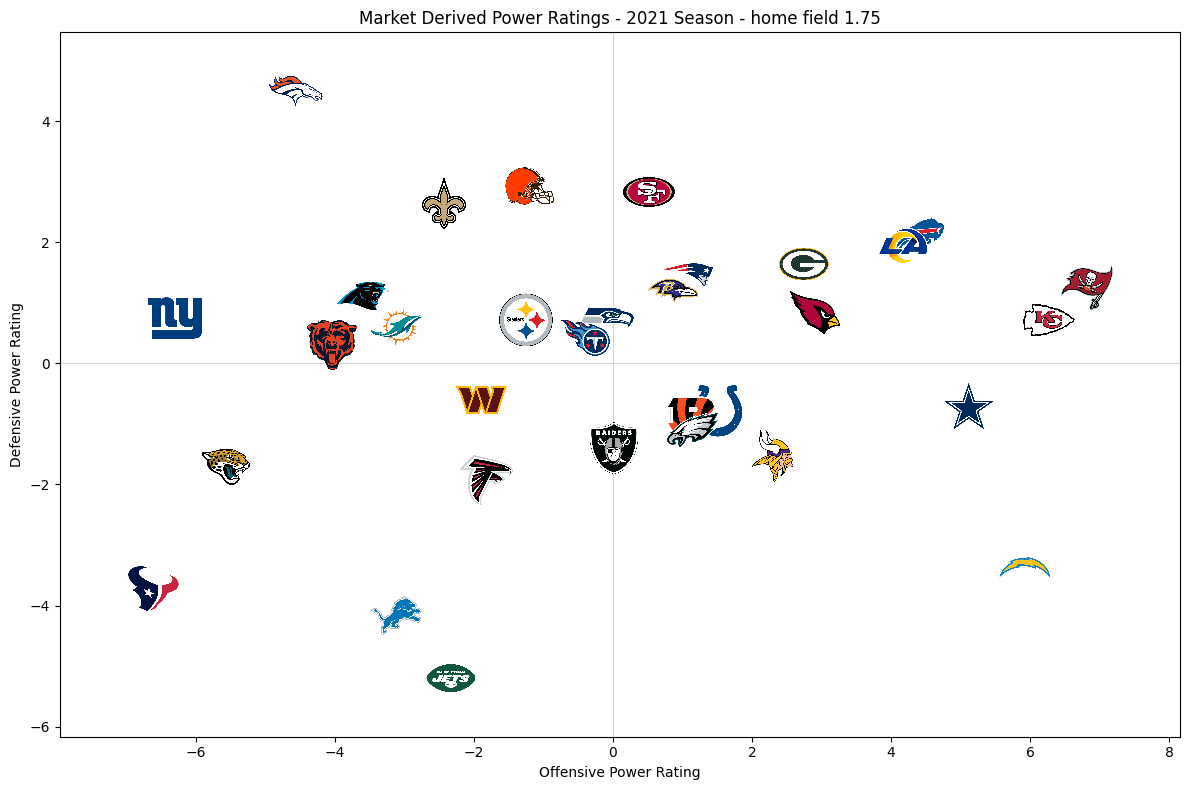

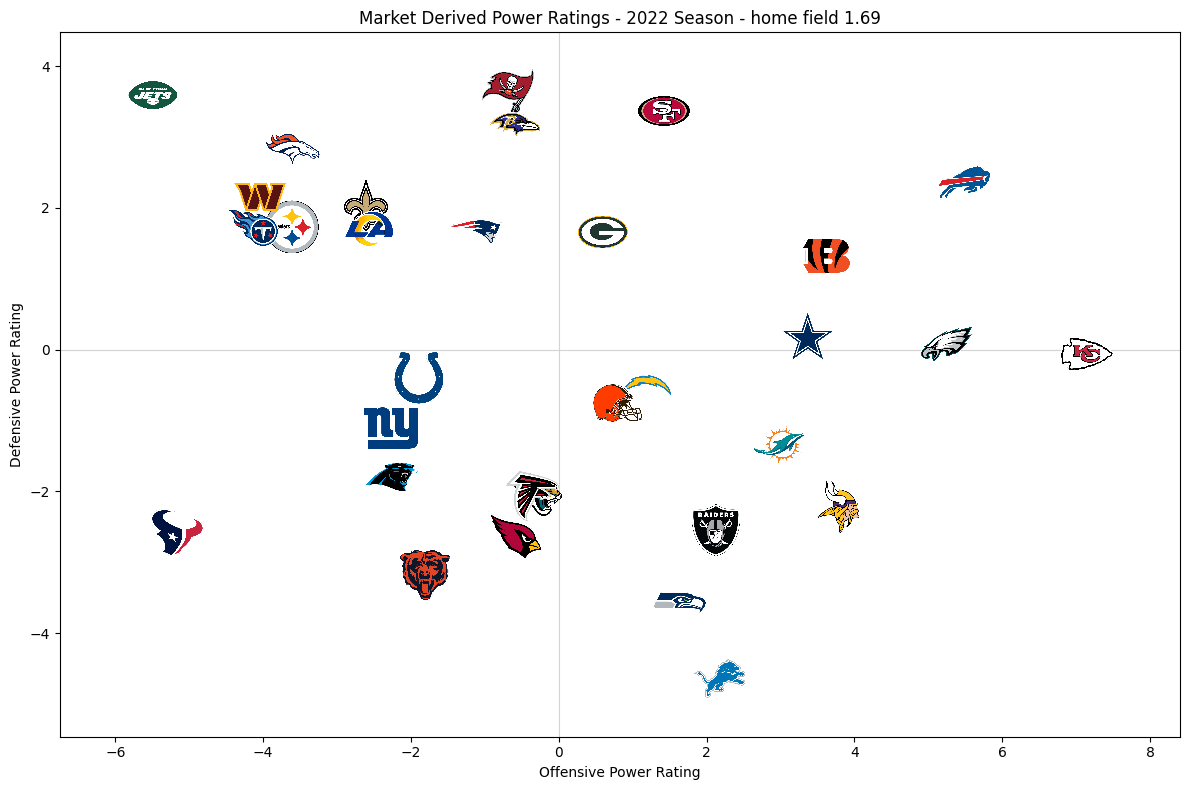

In [3]:
power_rating = {}
hfa = {}
for year in range(2018, 2023):
    pr, hf = derive_market_power_ratings(year)
    power_rating[year] = pr
    hfa[year] = hf
    _ = plot_team_scatter(pr, 'off', 'def', title=f'Market Derived Power Ratings - {year} Season - home field {hfa[year]}', ax_labels=('Offensive Power Rating', 'Defensive Power Rating'), mean_reference=False)